# Transformer para series de tiempo

## Importación de librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import os
from typing import Optional, Any, Union, Callable, Tuple

In [2]:
from torch import nn, Tensor
from torch.optim import Adam
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
import math

## Lectura de datos

Se importan los datos con los delitos homogenizados construidos anteriormente.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Proyecto_CD/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
FGJ_carpetas = pd.read_csv(path+'FGJ_carpetas_homo.csv', parse_dates=["fecha_hechos"]) 
FGJ_carpetas.index = pd.DatetimeIndex(FGJ_carpetas.fecha_hechos)

In [5]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[1:11]
cat = top_cat[top_cat!="HECHO NO DELICTIVO"]

In [ ]:
FGJ_carpetas[FGJ_carpetas["categoria_delito_homo"] == cat[0]]

In [7]:
ts_hour = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", index = FGJ_carpetas['fecha_hechos'].dt.to_period('H'), 
                        aggfunc=np.size, fill_value=0)

## Arquitectura

In [8]:
class PositionalEncoder(nn.Module):
    """Adapted from:  https://pytorch.org/tutorials/beginner/transformer_tutorial.html"""

    def __init__(self, dropout: float=0.1, 
        max_seq_len: int=5000, d_model: int=512,batch_first: bool=False):
        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
            pe[:, 0, 0::2] = torch.sin(position * div_term)
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [9]:
class TimeSeriesTransformer(nn.Module):
    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. 
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    """
    def __init__(self, input_size: int, dec_seq_len: int, batch_first: bool, out_seq_len: int=58, dim_val: int=512, 
                 n_encoder_layers: int=4, n_decoder_layers: int=4, n_heads: int=8,dropout_encoder: float=0.2, dropout_decoder: float=0.2,
                 dropout_pos_enc: float=0.1, dim_feedforward_encoder: int=2048,dim_feedforward_decoder: int=2048,
                 num_predicted_features: int=1): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """
        super().__init__() 
        self.dec_seq_len = dec_seq_len

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(in_features=input_size, out_features=dim_val)
        self.decoder_input_layer = nn.Linear(in_features=num_predicted_features,out_features=dim_val)  
        self.linear_mapping = nn.Linear(in_features=dim_val,out_features=num_predicted_features)

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder( d_model=dim_val,dropout=dropout_pos_enc)

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecode
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer,num_layers=n_encoder_layers,norm=None)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer,num_layers=n_decoder_layers, norm=None)

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """
        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        src = self.encoder(src=src) # src shape: [batch_size, enc_seq_len, dim_val]
        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(tgt=decoder_output,memory=src, tgt_mask=tgt_mask, memory_mask=src_mask)
        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        return decoder_output

In [10]:
class TransformerDataset(Dataset):
    """Dataset class used for transformer models."""
    def __init__(self, data: torch.tensor,indices: list, enc_seq_len: int, dec_seq_len: int, target_seq_len: int) -> None:

        """
        Args:
            data: tensor, the entire train, validation or test data sequence 
                        before any slicing. If univariate, data.size() will be 
                        [number of samples, number of variables]
                        where the number of variables will be equal to 1 + the number of
                        exogenous variables. Number of exogenous variables would be 0 if univariate.
            indices: a list of tuples. Each tuple has two elements:
                     1) the start index of a sub-sequence
                     2) the end index of a sub-sequence. 
                     The sub-sequence is split into src, trg and trg_y later.  
            enc_seq_len: int, the desired length of the input sequence given to the
                     the first layer of the transformer model.
            target_seq_len: int, the desired length of the target sequence (the output of the model)
            target_idx: The index position of the target variable in data. Data is a 2D tensor
        """      
        super().__init__()
        self.indices = indices
        self.data = data

        print("From get_src_trg: data size = {}".format(data.size()))

        self.enc_seq_len = enc_seq_len
        self.dec_seq_len = dec_seq_len
        self.target_seq_len = target_seq_len

    def __len__(self):        
        return len(self.indices)

    def __getitem__(self, index):
        """Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]
        sequence = self.data[start_idx:end_idx]

        #print("From __getitem__: sequence length = {}".format(len(sequence)))
        src, trg, trg_y = self.get_src_trg(
            sequence=sequence,
            enc_seq_len=self.enc_seq_len,
            dec_seq_len=self.dec_seq_len,
            target_seq_len=self.target_seq_len
            )
        return src, trg, trg_y
    
    def get_src_trg(self,sequence: torch.Tensor, enc_seq_len: int, dec_seq_len: int, target_seq_len: int) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        """
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        # encoder input
        src = sequence[:enc_seq_len] 
        # decoder input.
        trg = sequence[enc_seq_len-1:len(sequence)-1]
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"
        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]
        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"
        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

In [11]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


def get_indices_input_target(num_obs, input_len, step_size, forecast_horizon, target_len):
        """
        Produce all the start and end index positions of all sub-sequences.
        The indices will be used to split the data into sub-sequences on which 
        the models will be trained. 
        Returns a tuple with four elements:
        1) The index position of the first element to be included in the input sequence
        2) The index position of the last element to be included in the input sequence
        3) The index position of the first element to be included in the target sequence
        4) The index position of the last element to be included in the target sequence
        
        Args:
            num_obs (int): Number of observations in the entire dataset for which
                            indices must be generated.
            input_len (int): Length of the input sequence (a sub-sequence of 
                             of the entire data sequence)
            step_size (int): Size of each step as the data sequence is traversed.
                             If 1, the first sub-sequence will be indices 0-input_len, 
                             and the next will be 1-input_len.
            forecast_horizon (int): How many index positions is the target away from
                                    the last index position of the input sequence?
                                    If forecast_horizon=1, and the input sequence
                                    is data[0:10], the target will be data[11:taget_len].
            target_len (int): Length of the target / output sequence.
        """

        input_len = round(input_len) # just a precaution
        start_position = 0
        stop_position = num_obs-1 # because of 0 indexing
        
        subseq_first_idx = start_position
        subseq_last_idx = start_position + input_len
        target_first_idx = subseq_last_idx + forecast_horizon
        target_last_idx = target_first_idx + target_len 
        print("target_last_idx is {}".format(target_last_idx))
        print("stop_position is {}".format(stop_position))
        indices = []
        while target_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_last_idx, target_first_idx, target_last_idx))
            subseq_first_idx += step_size
            subseq_last_idx += step_size
            target_first_idx = subseq_last_idx + forecast_horizon
            target_last_idx = target_first_idx + target_len

        return indices

def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            num_obs (int): Number of observations (time steps) in the entire 
                           dataset for which indices must be generated, e.g. 
                           len(data)
            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [14]:
def read_data(data_dir: Union[str, Path] = "data",  
    timestamp_col_name: str="timestamp") -> pd.DataFrame:
    """
    Read data from csv file and return pd.Dataframe object
    Args:
        data_dir: str or Path object specifying the path to the directory 
                  containing the data
        target_col_name: str, the name of the column containing the target variable
        timestamp_col_name: str, the name of the column or named index 
                            containing the timestamps
    """

    # Ensure that `data_dir` is a Path object
    data_dir = Path(data_dir)

    # Read csv file
    csv_files = list(data_dir.glob("*.csv"))
    
    if len(csv_files) > 1:
        raise ValueError("data_dir contains more than 1 csv file. Must only contain 1")
    elif len(csv_files) == 0:
        raise ValueError("data_dir must contain at least 1 csv file.")

    data_path = csv_files[0]
    print("Reading file in {}".format(data_path))

    data = pd.read_csv(
        data_path, 
        parse_dates=[timestamp_col_name], 
        index_col=[timestamp_col_name], 
        infer_datetime_format=True,
        low_memory=False
    )

    # Make sure all "n/e" values have been removed from df. 
    if is_ne_in_df(data):
        raise ValueError("data frame contains 'n/e' values. These must be handled")

    data = to_numeric_and_downcast_data(data)
    # Make sure data is in ascending order by timestamp
    data.sort_values(by=[timestamp_col_name], inplace=True)

    return data

def is_ne_in_df(df:pd.DataFrame):
    """
    Some raw data files contain cells with "n/e". This function checks whether
    any column in a df contains a cell with "n/e". Returns False if no columns
    contain "n/e", True otherwise
    """
    for col in df.columns:
        true_bool = (df[col] == "n/e")
        if any(true_bool):
            return True

    return False


def to_numeric_and_downcast_data(df: pd.DataFrame):
    """Downcast columns in df to smallest possible version of it's existing data type"""
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df

In [15]:
def run_encoder_decoder_inference(model: nn.Module, src: torch.Tensor, forecast_window: int,batch_size: int,device, batch_first: bool=False) -> torch.Tensor:
    """
    NB! This function is currently only tested on models that work with batch_first = False
    This function is for encoder-decoder type models in which the decoder requires
    an input, tgt, which - during training - is the target sequence. During inference,
    the values of tgt are unknown, and the values therefore have to be generated iteratively.  
    This function returns a prediction of length forecast_window for each batch in src
    
    Args:
        model: An encoder-decoder type model where the decoder requires
               target values as input. Should be set to evaluation mode before 
               passed to this function.
        src: The input to the model
        forecast_horizon: The desired length of the model's output, e.g. 58 if you
                         want to predict the next 58 hours of FCR prices.
        batch_size: batch size
        batch_first: If true, the shape of the model input should be 
                     [batch size, input sequence length, number of features].
                     If false, [input sequence length, batch size, number of features]
    """

    # Dimension of a batched model input that contains the target sequence values
    target_seq_dim = 0 if batch_first == False else 1
    # Take the last value of thetarget variable in all batches in src and make it tgt as per the Influenza paper
    tgt = src[-1, :, 0] if batch_first == False else src[:, -1, 0] # shape [1, batch_size, 1]
    # Change shape from [batch_size] to [1, batch_size, 1]
    if batch_size == 1 and batch_first == False:
        tgt = tgt.unsqueeze(0).unsqueeze(0) # change from [1] to [1, 1, 1]
    # Change shape from [batch_size] to [1, batch_size, 1]
    if batch_first == False and batch_size > 1:
        tgt = tgt.unsqueeze(0).unsqueeze(-1)

    # Iteratively concatenate tgt with the first element in the prediction
    for _ in range(forecast_window-1):
        # Create masks
        dim_a = tgt.shape[1] if batch_first == True else tgt.shape[0]
        dim_b = src.shape[1] if batch_first == True else src.shape[0]
        tgt_mask = generate_square_subsequent_mask(dim1=dim_a,dim2=dim_a,device=device)
        src_mask = generate_square_subsequent_mask(dim1=dim_a,dim2=dim_b,device=device)

        # Make prediction
        prediction = model(src, tgt, src_mask, tgt_mask) 

        # If statement simply makes sure that the predicted value is 
        # extracted and reshaped correctly
        if batch_first == False:
            # Obtain the predicted value at t+1 where t is the last time step represented in tgt
            last_predicted_value = prediction[-1, :, :] 
            # Reshape from [batch_size, 1] --> [1, batch_size, 1]
            last_predicted_value = last_predicted_value.unsqueeze(0)

        else:
            # Obtain predicted value
            last_predicted_value = prediction[:, -1, :]
            # Reshape from [batch_size, 1] --> [batch_size, 1, 1]
            last_predicted_value = last_predicted_value.unsqueeze(-1)

        # Detach the predicted element from the graph and concatenate with tgt in dimension 1 or 0
        tgt = torch.cat((tgt, last_predicted_value.detach()), target_seq_dim)
    
    # Create masks
    dim_a = tgt.shape[1] if batch_first == True else tgt.shape[0]
    dim_b = src.shape[1] if batch_first == True else src.shape[0]
    tgt_mask = generate_square_subsequent_mask(dim1=dim_a,dim2=dim_a,device=device)
    src_mask = generate_square_subsequent_mask(dim1=dim_a,dim2=dim_b,device=device)

    # Make final prediction
    final_prediction = model(src, tgt, src_mask, tgt_mask)

    return final_prediction

# Datos y entrenamiento

In [72]:
# Hyperparams
test_size = 0.2
batch_size = 128

## Params
dim_val = 216 #512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 46 # 92 # length of input given to decoder
enc_seq_len = 168 #153 # length of input given to encoder
output_sequence_length = 48 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 168 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 1024
in_features_decoder_linear_layer = 1024
max_seq_len = enc_seq_len
batch_first = True
learning_rate = 1e-3

In [73]:
data = pd.DataFrame({'FCR_N_PriceEUR':ts_hour['AMENAZAS'].values,'timestamp':ts_hour.index})
data.head()

,FCR_N_PriceEUR,timestamp
0,3,2016-01-01 00:00
1,3,2016-01-01 01:00
2,0,2016-01-01 02:00
3,0,2016-01-01 03:00
4,0,2016-01-01 04:00


In [74]:
target_col_name = "FCR_N_PriceEUR"
timestamp_col = "timestamp"
# Only use data from this date and onwards
cutoff_date = datetime(2018, 1, 1) 

In [75]:
# Define input variables 
exogenous_vars = [] # should contain strings. Each string must correspond to a column name
input_variables = [target_col_name] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y
input_size = len(input_variables)

In [58]:
# Read data
#data = read_data(timestamp_col_name=timestamp_col)

In [76]:
# Remove test data from dataset
training_data = data[:-(round(len(data)*test_size))]
# Make list of (start_idx, end_idx) pairs that are used to slice the time series sequence into chunkc. 
# Should be training data indices only
training_indices = get_indices_entire_sequence(data=training_data, window_size=window_size, step_size=step_size)
# Making instance of custom dataset class
training_data = TransformerDataset(data=torch.tensor(training_data[input_variables].values).float(),indices=training_indices,enc_seq_len=enc_seq_len,dec_seq_len=dec_seq_len,target_seq_len=output_sequence_length)
# Making dataloader
training_data = DataLoader(training_data, batch_size)

i, batch = next(enumerate(training_data))
src, trg, trg_y = batch
print("src shape {}".format(src.shape))
print("src shape {}".format(src.shape))
# Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
#if batch_first == False:
#    shape_before = src.shape
#    src = src.permute(1, 0, 2)
#    shape_before = trg.shape
#    trg = trg.permute(1, 0, 2)

From get_src_trg: data size = torch.Size([45552, 1])
src shape torch.Size([128, 168, 1])
src shape torch.Size([128, 168, 1])


In [77]:
model = TimeSeriesTransformer(input_size=len(input_variables),dec_seq_len=enc_seq_len,batch_first=batch_first,
                              num_predicted_features=1)

In [78]:
epochs = 1

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = MSELoss()

# Iterate over all epochs
for epoch in range(epochs):
    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, trg, tgt_y) in enumerate(training_data):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Make src mask for decoder with size:  [batch_size*n_heads, output_sequence_length, enc_seq_len]
        src_mask = generate_square_subsequent_mask(dim1=output_sequence_length,dim2=enc_seq_len)
        # Make tgt mask for decoder with size:[batch_size*n_heads, output_sequence_length, output_sequence_length]
        tgt_mask = generate_square_subsequent_mask(dim1=output_sequence_length,dim2=output_sequence_length)

        if batch_first == False:
          src = src.permute(1, 0, 2)
          trg = trg.permute(1, 0, 2)

        # Make forecasts
        prediction = model(src=src,tgt=trg,src_mask=src_mask,tgt_mask=tgt_mask)
  
        if input_size==1:
          tgt_y = tgt_y.unsqueeze(2)
        # Compute and backprop loss
        loss = criterion(tgt_y, prediction)
        loss.backward()
        # Take optimizer step
        optimizer.step()

    # Iterate over all (x,y) pairs in validation dataloader
    #model.eval()
    #with torch.no_grad():
    #    for i, (src, _, tgt_y) in enumerate(training_data):
    #        prediction = run_encoder_decoder_inference(model=model, src=src, forecast_window=output_sequence_length,batch_size=src.shape[1])
    #        loss = criterion(tgt_y, prediction)

In [ ]:
i, batch = next(enumerate(training_data))
src, trg, trg_y = batch
model.eval()
with torch.no_grad():
  prediction = model(src=src,tgt=trg,src_mask=src_mask,tgt_mask=tgt_mask)

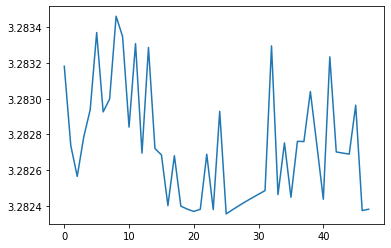

In [81]:
plt.plot(prediction[0])